In [1]:
from qusim import optical, detector, source, extsource
from qusim import gsense_4040 as gs
#gs=qusim.gsense_4040
gs.tele.external['zodiac']=7e-2
gs.bandlims=[[200,365]]
print(gs.get_sens(1))

srtest=source(22)
srtest.set_band(gs.bandlims[0])
import math
modelB=gs.tele
modelB.diameter=300
modelB.foclength=1066
modelB.psf=3 #arcsec
modelB.beamsplitter=0.95

import numpy as np
singexp=[1,2,4,6,8]
pixrad=np.array([1,2.2,3.4,4.5,5.6])#*1850/gs.tele.foclength

gs.tele.psf=2.2*gs.pixsize/gs.tele.foclength/math.pi*1e-3*180*60*60
gs.angsize()

0.4592157894736842


1.7414477075270802

In [2]:
import qusim
bkg=qusim.extsource(25)
bkg.set_band(gs.bandlims[0])
import qusim
qusim.gtrack=0
allexp=np.r_[60:2500:60]
pixrad=np.array([1,2.3,3.4,4.5,5.6])#/1850*gs.tele.foclength

In [3]:
from imp import reload
reload(qusim)

<module 'qusim' from '/home/limu/Code/Notebook/Astro/quvik/qusim.py'>

In [4]:
gs.tele.effective(1)*gs.get_sens(0)

0.020155095108468232+/-0.0004687231420574008

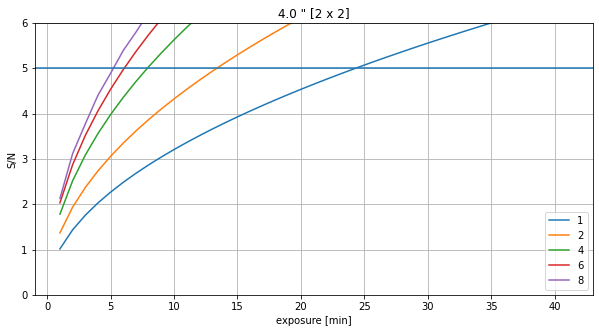

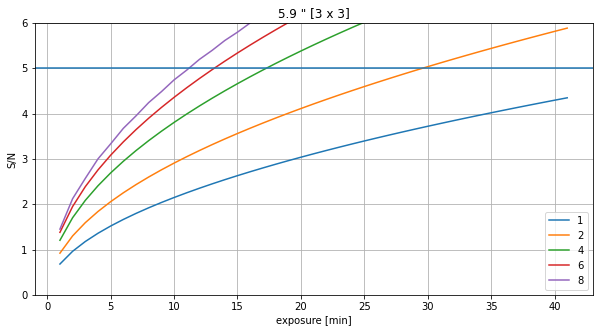

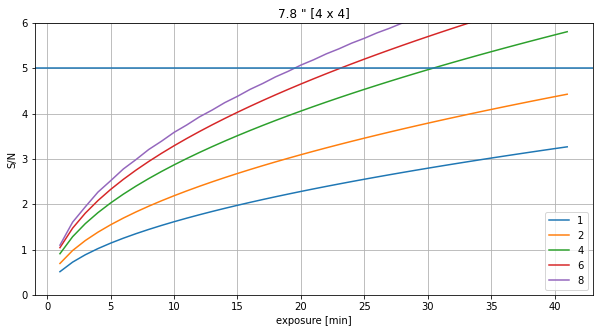

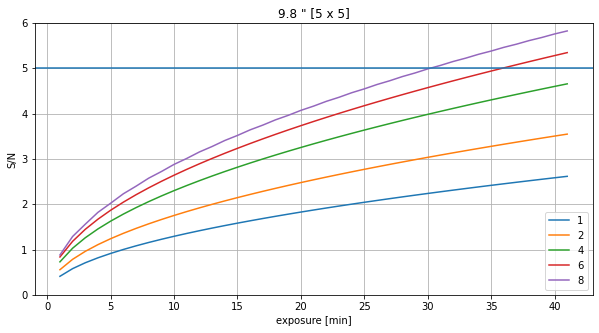

In [5]:
from matplotlib import pyplot as pl
allexp=np.r_[60:2500:60] # in sec
bkg=extsource(23)
for j in range(1,5):
    pl.figure(figsize=(10,5))
    gs.tele.psf=pixrad[j]*gs.pixsize/gs.tele.foclength/math.pi*1e-3*180*60*60
    allsn=np.array([[gs.expose(0,srtest,[bkg],integ=tread,accum=int(expos/tread)).n for tread in singexp] for expos in allexp])
    [pl.plot(allexp/60,sn) for sn in allsn.T];
    pl.xlabel('exposure [min]')
    pl.ylabel('S/N')
    pl.legend(singexp)
    pl.ylim(0,6)
    pl.title("%.1f \" [%i x %i]"%(gs.tele.psf,j+1,j+1))
    pl.axhline(5)
    pl.grid()

In [6]:
tread=4
expos=60
qsig=gs.elecrate(srtest,0)*tread*int(expos/tread)
#qsig*gs.tele.effective()
qsig

64.56937125264663+/-1.5016132849452706

In [7]:
assert np.isclose(gs.pixsize/gs.tele.foclength/math.pi*1e-3*180*gs.npix,1.9814)

## treat STM

In [52]:
import pandas as pd
cols=[0,1,2]+list(range(3,11,2))+[11,13,14,16]+list(range(17,28,2))
fultab=pd.read_excel("/home/limu/Documents/Space/QUVIK/Science/STM_combined.xlsx",usecols=cols,skiprows=[1])
ql=[a for a in fultab.mag_max if a!=float('nan')]#pd.NaN]
#type(ql[1])
zoo=np.array(ql).astype(float)
zsel=np.isnan(zoo)==False
fultab.at[0,'ObsDuration']=10
zoo[zsel]#fultab.mag_max

array([22., 17., 17., 16., 17., 17., 19., 19., 19., 20., 21., 21., 21.,
       21., 23., 23., 24., 16., 14., 15., 12.])

In [43]:
qcon=np.log(10)*0.4

prec=fultab.PhotPrecision.to_numpy()
prec2=1/fultab.S2N.to_numpy()
nsel=(np.isnan(prec2)==False)
prec[nsel]=prec2[nsel]

expo=fultab.ObsDuration.to_numpy()
expo2=fultab.ObsLatency.to_numpy()
nsel=np.isnan(expo)*(np.isnan(expo2)==False)
expo[nsel]=expo2[nsel]

bga=extsource(23)
quads=lambda a,b,c:(np.sqrt(b**2-4*a*c)-b)/2/a

#srb.photrate(efsurface),gsense_4040.elecount(srb)
#quads2=lambda a,b,c:(-np.sqrt(b**2-4*a*c)-b)/2/a
def calc_surface(delta,expos=120,sr_mag=21,npix=4,integ=4,band=0):
    '''delta=noise/signal
    returns eff. surface in cm^2
    '''
    srb=source(sr_mag)
    pixnoise=det.darkrate*npix+det.readout**2*npix/integ
    #qe=det.get_sens(band)
    #ind2=[0,-det.angsize()**2*bga.photrate(surface=1)*npix*qe,-pixnoise]
    #ind2[0]=(delta*srb.photrate(surface=1)*qe)**2*expos

    ind2=[0,-det.angsize()**2*det.elecrate(bga,band,surf=1,grid=5)*npix,-pixnoise]#photrate(surface=1,band=band)*npix,-pixnoise]
    srate=det.elecrate(srb,band,surf=1,grid=5)
    ind2[0]=(delta*srate)**2*expos
    ind2[1]-=srate
    return quads(*ind2)*1e4

In [56]:
sur1

0.014183113338320789

In [57]:
det=gs              
sur1=calc_surface(0.2,600,22,band=0)
#sur1=200
srb=source(22)
det.exposure=600
sur1,det.elecrate(srb,0,surf=sur1*1e-4)*det.exposure

(384.0752666339901, 536.7826423679628)

In [73]:
modelB.effective(1)

0.04389024848550692+/-0.0010207034531513237

In [71]:
i=pos[0]
mag=zoo[i]
expo[i]=10
qusim.ggrid=5
sur1=calc_surface(0.2,expo[i]*60,mag,band=0)*1e-4
det.normsurf=sur1
#del det.normsurf
srb=source(mag)
#srb.set_band(det.bandlims[0])
det.exposure=4
accum=expo[i]*60/4
gs.tele.psf=2.3*gs.pixsize/gs.tele.foclength/math.pi*1e-3*180*60*60
qusim.gtrack=2
noi=det.psfnoise([bga],0,accum=accum,src=srb).n
print(sur1,det.elecrate(srb,0,surf=sur1,grid=5)*det.exposure*accum/noi)
del det.normsurf

4 pixels
1.1238487911585004 photelectrons, 0.04 dark, 3.9 from readout
0.038407526663399014 4.949645185404682


In [64]:
expo[i]

30.0

In [74]:
nsel=np.isnan(prec)==False
pos=np.where(nsel*zsel)[0]
nrsurf=0.02/det.get_sens(0)
i=pos[0]
npix=4
integ=4
noi=(det.darkrate*npix+det.readout**2*npix/integ)
#noi+=det.angsize()**2*bga.photrate(surface=nrsurf)*npix
noi+=det.angsize()**2*det.elecrate(bga,0,grid=5)*npix
src=source(zoo[i])
src.set_band(det.bandlims[0])
srt=det.elecrate(src,0,grid=5)
noi+=srt#c.photrate(surface=nrsurf)

tim=noi/(srt*prec[i]*qcon)**2
qusim.ggrid=5
tim,prec[i]*det.expose(0,src,[bga],integ,int(tim.n/integ)).n

4 pixels
1.352+/-0.031 photelectrons, 0.04 dark, 3.9 from readout


(514.6921927281971+/-20.3712218314012, 1.0770938976211901)

In [75]:
qusim.ggrid=5
prec[i]*det.expose(0,src,[bga],integ,int(tim.n/integ)).n

4 pixels
1.352+/-0.031 photelectrons, 0.04 dark, 3.9 from readout


1.0770938976211901

In [86]:

nsel=np.isnan(prec)==False
pos=np.where(nsel*zsel)[0]
#expos=fultab.ObsLatency
surfs=[]
surfg=[]
limex=[]
integ=4
npix=9
chekx=[]
qusim.gtrack=0
dsens0=det.get_sens(0)
gs.tele.psf=3.4*gs.pixsize/gs.tele.foclength/math.pi*1e-3*180*60*60

nrsurf=0.0200/dsens0 #normalized surface
#qe=det.get_sens(1) #already included in nrsurf
for i in pos:
    surfs.append(int(calc_surface(delta=prec[i],expos=expo[i]*60,sr_mag=zoo[i],npix=npix,integ=integ)*dsens0))
    surfg.append(int(calc_surface(delta=prec[i],expos=1,sr_mag=zoo[i],npix=4,integ=1)*dsens0))
    noi=(det.darkrate*npix+det.readout**2*npix/integ)
    noi+=det.angsize()**2*det.elecrate(bga,0,surf=nrsurf,grid=5)*npix
    src=source(zoo[i])
    #noi+=det.angsize()**2*bga.photrate(surface=nrsurf)*npix
    src.set_band(det.bandlims[0])
    srt=det.elecrate(src,0,surf=nrsurf,grid=5)
    noi+=srt#c.photrate(surface=nrsurf)
    #noi+=src.photrate(surface=nrsurf)
    tim=noi/(srt*prec[i]*qcon)**2
    limex.append(tim/60) #time to reach S/N=prec with nrsurf 
    try:
        chekx.append(prec[i]*det.expose(0,src,[bga],integ,int(tim/integ)).n)
    except:
        chekx.append(0)
limex=(np.array(limex)*10).astype('int')/10

In [87]:
np.min(chekx),np.max(chekx)

(1.1121593560662146, 1.1398101866680328)

In [88]:
obje,wg=fultab.Objective[pos],fultab.WG[pos]
#repe=(fultab.img_rate[pos].to_numpy()*16).astype(int)
#repe[repe<0]=0
repe=fultab.img_rate[pos]
outab={'group':wg,'objective':obje,'magnitude':zoo[pos],'precis':prec[pos],'surf_1s':surfg,'optim_expo':expo[pos],'repeat':repe,'expo_200cm':limex,'optim_surf':surfs}
outab['band1']=fultab.band1[pos]
outab['band2']=fultab.band2[pos]
outframe=pd.DataFrame(data=outab)
outframe.to_excel("/home/limu/Documents/Space/QUVIK/Science/Science_requirem3.xlsx")
outframe

,group,objective,magnitude,precis,surf_1s,optim_expo,repeat,expo_200cm,optim_surf,band1,band2
0,KN,kilonovae detection,22.0,0.200,29469,10.0,1,20.7,279,200-260,260-400
2,ST,BA star surface,17.0,0.001,1986336,5.0,18,267.3,7060,both needed,NaN
4,ST,peculiar warps,17.0,0.001,1986336,1.0,90,267.3,35069,"both needed, UV prefer",NaN
5,ST,wind instabil,16.0,0.001,768850,0.5,180,86.9,26256,"both needed, UV prefer",NaN
8,ST,cool SG loss,17.0,0.010,19971,1.0,0.066667,2.6,401,both needed,NaN
9,ST,pulsating models,17.0,0.001,1986336,5.0,18,267.3,7060,"both needed, UV",NaN
10,AG,disc model,19.0,0.005,624463,10.0,0.066667,176.2,1555,both needed,NaN
11,AG,TDE physics,19.0,0.005,624463,10.0,0.066667,176.2,1555,NaN,NaN
12,AG,change look,19.0,0.005,624463,10.0,0.066667,176.2,1555,-300,NaN
13,BN,symbiotic stats,20.0,0.010,531169,60.0,NaN,233.4,428,any,NaN


In [14]:
#(fultab.img_rate[pos])
srtest.photrate(surface=0.0200)

0.46095051749824495

In [54]:
gs.bandlims

[[200, 365]]

In [15]:
source(22).energy()

5.376903870162296